In [1]:
import numpy as np
from math import *
from matplotlib import cm
from matplotlib import pyplot as plt
import time

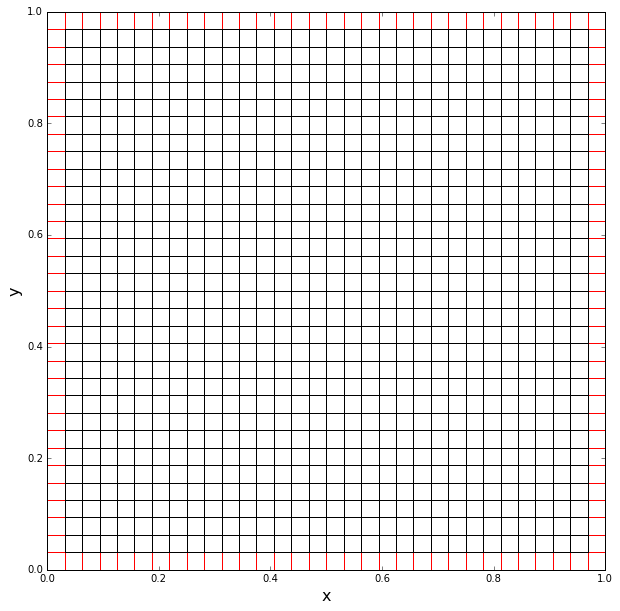

In [2]:
Nx = 32
Ny = 32

Lx = 1.0
Ly = 1.0

dx = Lx/(Nx)
dy = Ly/(Ny)


mu=0.0025
U=1.0

# Staggered Grid

x_start,x_end = 0.0,Lx
y_start,y_end = 0.0,Ly

y = np.linspace(y_start,y_end,Ny+1)
x = np.linspace(x_start,x_end,Nx+1)

# Pressure 
p= np.zeros((Nx+2,Ny+2),dtype=float)

#U velocity
u = np.zeros((Nx+1,Ny+2),dtype=float)
ut = np.zeros((Nx+1,Ny+2),dtype=float)

#v velocity
v = np.zeros((Nx+2,Ny+1),dtype=float)
vt = np.zeros((Nx+2,Ny+1),dtype=float)


X,Y= np.meshgrid(x,y)

%matplotlib inline

size = 10
plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*10))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
#plt.xlim(x_start-dx, x_end+dy)
#plt.ylim(y_start-dy, y_end+dy)
plt.plot(X,Y,color='red')
plt.plot(X.T,Y.T,color='red')
plt.plot(X[1:-1,1:-1], Y[1:-1,1:-1],color='black')
plt.plot(X[1:-1,1:-1].T, Y[1:-1,1:-1].T,color='black')
plt.plot(X[0,:], Y[0,:],color='red')
plt.plot(X[-1,:], Y[-1,:],color='red')
plt.plot(X[:,0], Y[:,0], color='red')
plt.plot(X[:,-1], Y[:,-1],color='red')



In [3]:
def F1c(ue,uw,us,un,vs,vn,dx,dy):
    F1c=-((ue**2)-(uw**2))/dx - ((un*vn)-(us*vs))/dy
    return F1c

In [4]:
def Fv(uP,uE,uW,uN,uS,dx,dy,mu):
    Fv=(mu/dx)*(((uE-uP)/dx)-((uP-uW)/dx)) + (mu/dy)*(((uN-uP)/dy)-((uP-uS)/dy))
    return Fv 

In [5]:
def F2c(vn,vs,ve,vw,ue,uw,dx,dy):
    F2c= -((ue*ve)-(uw*vw))/dx - ((vn**2)-(vs**2))/dy
    return F2c

In [6]:
#Simulation parameters

t=0
tmax=100

#dt=0.05*(min(dx,dy))**2/Re
dt = dx*0.05
nt = int((tmax-t)/dt)

maxit = 1500

tstep = 0

#simlations

while(tstep<nt):
    
    #predictor
               
    ue1=(u[1:-1,1:-1]+u[2:,1:-1])/2
    uw1=(u[1:-1,1:-1]+u[:-2,1:-1])/2
    un1=(u[1:-1,1:-1]+u[1:-1,2:])/2
    us1=(u[1:-1,1:-1]+u[1:-1,:-2])/2
    vn1=(v[1:-2,1:]+v[2:-1,1:])/2
    vs1=(v[1:-2,:-1]+v[2:-1,:-1])/2
    
    
    
    uP = (u[1:-1,1:-1])
    uE = (u[2:,1:-1])
    uW = (u[:-2,1:-1])
    uN = (u[1:-1,2:])
    uS = (u[1:-1,:-2])
    
    
    if tstep==0:
        G1=(F1c(ue1,uw1,us1,un1,vs1,vn1,dx,dy))+Fv(uP,uE,uW,uN,uS,dx,dy,mu)
        ut[1:-1,1:-1]=u[1:-1,1:-1]+(dt/1)*G1
        G1_old=G1.copy()
        
               
    else:
        
        G1=(F1c(ue1,uw1,us1,un1,vs1,vn1,dx,dy))+Fv(uP,uE,uW,uN,uS,dx,dy,mu)
        ut[1:-1,1:-1]=u[1:-1,1:-1]+(dt/2)*(3*G1-G1_old)
        G1_old=G1.copy()

    ve12=(v[1:-1,1:-1]+v[2:,1:-1])/2
    vw12=(v[1:-1,1:-1]+v[:-2,1:-1])/2
    vn12=(v[1:-1,1:-1]+v[1:-1,2:])/2
    vs12=(v[1:-1,1:-1]+v[1:-1,:-2])/2
    ue12=(u[1:,1:-2]+u[1:,2:-1])/2
    uw12=(u[:-1,1:-2]+u[:-1,2:-1])/2
    
    vP = (v[1:-1,1:-1])
    vE = (v[2:,1:-1])
    vW = (v[:-2,1:-1])
    vN = (v[1:-1,2:])
    vS = (v[1:-1,:-2])
    
    
    if tstep==0:
        G2=(F2c(vn12,vs12,ve12,vw12,ue12,uw12,dx,dy)) + Fv(vP,vE,vW,vN,vS,dx,dy,mu)
        vt[1:-1,1:-1]=v[1:-1,1:-1]+(dt/1)*G2
        G2_old=G2.copy()
            
    else:
        
        G2=(F2c(vn12,vs12,ve12,vw12,ue12,uw12,dx,dy))+ Fv(vP,vE,vW,vN,vS,dx,dy,mu)
        vt[1:-1,1:-1]=v[1:-1,1:-1]+(dt/2)*(3*G2-G2_old)
        G2_old=G2.copy()
            
    #Boundary conditions
    ut[:,0]=-ut[:,1] #Bottom boundary condition
    ut[:,-1]=2-ut[:,-2] #Top Boundary condition
    
    vt[0,:]=-vt[1,:] #Left Boundary condition
    vt[-1:]=-vt[-2,:] #Right Boundary condition

    ut[0,:] = 0.0
    ut[-1,:] = 0.0
    vt[:,0] = 0.0
    vt[:,-1] = 0.0
    
  
    
    #Poissions equation
    p_counter = 0
    
    while (p_counter<maxit):
    
        p_old = p.copy()
        
        
        p[1:Nx+1,1:Ny+1]=0.25*((p_old[1:Nx+1,2:Ny+2]+p_old[1:Nx+1,:Ny]+\
                        p_old[2:Nx+2,1:Ny+1]+p_old[:Nx,1:Ny+1])-(dy/dt)*(vt[1:Nx+1,1:Ny+1]-\
                        vt[1:Nx+1,:Ny])-(dx/dt)*(ut[1:Nx+1,1:Ny+1]-ut[:Nx,1:Ny+1]))
        
        #Boundary conditions
        p[:,0]=p[:,1]
        p[:,-1]=p[:,-2]
        p[0,:]=p[1,:]
        p[-1,:]=p[-2,:]
    
        p_counter = p_counter + 1
    
        rms_error = sqrt(sum(sum((p-p_old)**2))/np.size(p))
        if (rms_error<10**-6 and rms_error !=0):
            break

    # Corrector step
    
    u[1:-1,1:-1]=ut[1:-1,1:-1]-(dt/(dx))*(p[2:-1,1:-1]-p[1:-2,1:-1])
    v[1:-1,1:-1]=vt[1:-1,1:-1]-(dt/(dy))*(p[1:-1,2:-1]-p[1:-1,1:-2])

    #Boundary conditions for correct velocities
    
    u[:,0]=-u[:,1]     # Bottom boundary condition
    u[:,-1]=2-u[:,-2]   # Top Boundary condition
    
    v[0,:]=-v[1,:]       #Left Boundary condition
    v[-1,:]=-v[-2,:]     #Right Boundary condition
    
    u[0,:] = 0.0
    u[-1,:] = 0.0
    v[:,0] = 0.0
    v[:,-1] = 0.0

    
    #End time loop
    tstep+=1
    

In [7]:
uu=(u[:,:-1]+u[:,1:])*0.5
vv=(v[:-1,:]+v[1:,:])*0.5

uu=uu.T
vv=vv.T

In [10]:
print (uu)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.13334188e-04   2.65522436e-04 ...,   3.28046522e-03
    1.09523199e-03   0.00000000e+00]
 [  0.00000000e+00  -5.13371470e-05  -1.08984015e-03 ...,   4.53664576e-03
    1.67132757e-03   0.00000000e+00]
 ..., 
 [  0.00000000e+00  -5.84333142e-02  -6.49077958e-02 ...,   2.06367264e-01
    6.73875194e-02   0.00000000e+00]
 [  0.00000000e+00   5.30742552e-02   1.27897497e-01 ...,   4.39610131e-01
    2.48018397e-01   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   0.00000000e+00]]


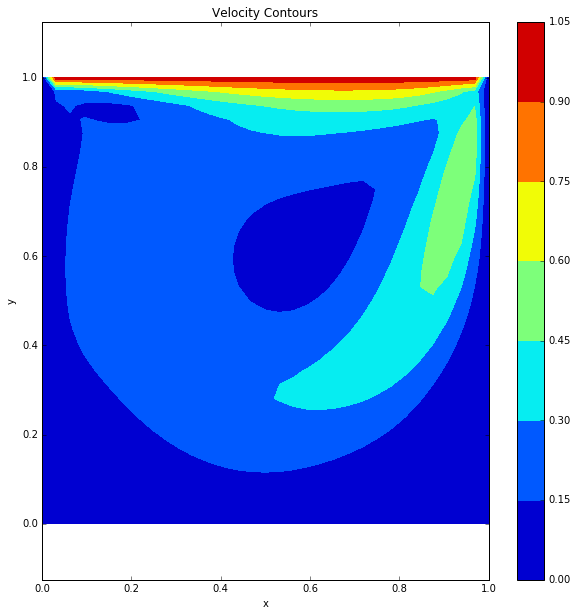

In [8]:
%matplotlib inline

# Contours of velocity magnitude
plt.figure(figsize=(size, (1.-0)/(1.-0)*size))
plt.contourf(X,Y,np.sqrt(uu**2+vv**2))
plt.colorbar()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity Contours')
plt.show()

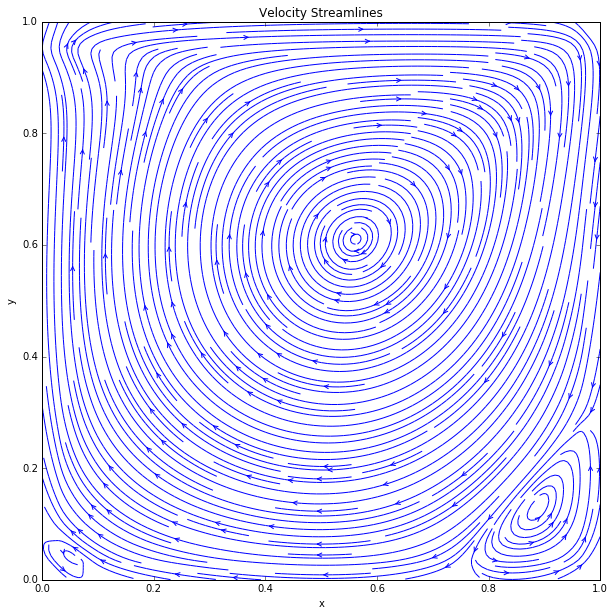

In [9]:
# Streamlines
plt.figure(figsize=(size, (1.-0)/(1.-0)*size))
plt.plot([0,0,1,1,0],[0,1,1,0,0],'k')
plt.streamplot(X, Y, uu, vv, density=3, arrowsize=1, arrowstyle='->')
plt.axis([0, 1, 0, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity Streamlines')
plt.show()